# Tutorial 3: DQN and introduction to off-policy 
+ What is DQN 
+ How is it related to SARSA
+ How do y1ou implement it 



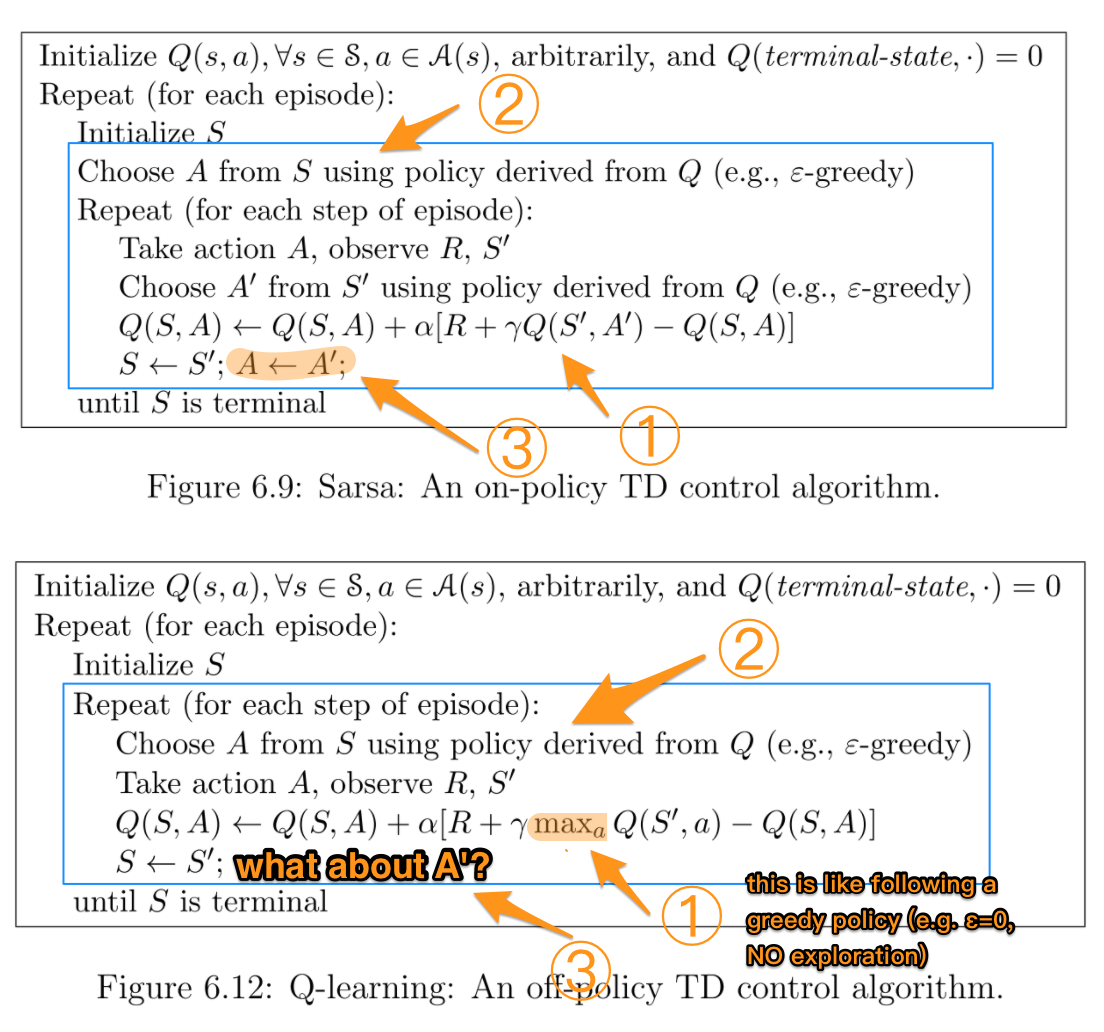

Why does SARSA learn the near optimal policy?

Is Q-Learning: 
1) On policy 
2) Off Policy 

In [1]:
import numpy as np

# Define discrete 2D states S,S'
GRID_WORLD = np.zeros((5,5))

# Discount Factor
GAMMA = 0.9

# Environment 
GRID_WORLD


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [2]:
# Define Actions (A) --> North, South, East, West 

actions = [[-1,0], [1,0], [0,-1], [0,1]]

Replay buffer as this is an off-policy algorithm which requires to store older experiences 


In [3]:
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        minibatch = random.choices(self.buffer, k=batch_size)
        return minibatch

    def __len__(self):
        return len(self.buffer)


In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np




class DeepQNetwork(nn.Module):
    def __init__(self, lr, 
                 input_dims, 
                 fc1_dims, 
                 fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state.float()))
        actions = self.fc2(x)
        return actions


class Agent:
    def __init__(self, gamma=0.9, epsilon=0.9, lr=3e-4, input_dims=2, batch_size=16, n_actions=4,
                 max_mem_size=int(10e3), eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.model = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=32)
        self.state_memory = np.zeros((self.mem_size, input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def sample_action(self, observation, epsilon=None):
        if epsilon!=None:
            self.epsilon = epsilon
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.model.device)
            actions = self.model.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.model.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        # Choose a random batch
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # Replace=False, dont select the same memories 
        batch_index = np.arange(self.batch_size, dtype=np.int32) # 

        # Extract the transition states of the batch from the memory
        state_batch = T.tensor(self.state_memory[batch]).to(self.model.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.model.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.model.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.model.device)

        # Evaluate and compute loss
        q_eval = self.model.forward(state_batch)[batch_index, action_batch]
        q_next = self.model.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        y = reward_batch + self.gamma*T.max(q_next, dim=1)[0] # reuurns actions + index tuple, we only need the action index

        loss = self.model.criterion(y, q_eval).to(self.model.device)
        loss.backward()
        self.model.optimizer.step()

        # Optionally decrease exploration, making policy more deterministic over time 
        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min
                        
    def load(self, name):
        self.model.load_state_dict(T.load(name))

    def save(self, name):
        T.save(self.model.state_dict(), name)



In [5]:
def env_step(state_id, action, action_idx):

    prime_state_id = state_id + action
    termination = False
    
    if (prime_state_id < 0).any() or (prime_state_id > 4).any():
        reward_t = -1
        prime_state_id = state_id
                        
    elif (state_id == [0,1]).all():
        reward_t = +10
        prime_state_id = [4,1]
        termination = True

    elif (state_id == [0,3]).all():
        reward_t = +5
        prime_state_id = [2,3]
        termination = True

    else:
        reward_t = -1
        
    return state_id, action_idx, reward_t, prime_state_id, termination


In [6]:
from tqdm import tqdm

total_timesteps = int(10e3)
timesteps = 10
termination = False
truncation = False


agent = Agent()

pbar = tqdm(total=total_timesteps, desc="Training Progress")


class FinishTraining(Exception):
    pass

rewards = []
try: 
    while True:
        
        i = np.random.choice(GRID_WORLD.shape[0]) 
        j = np.random.choice(GRID_WORLD.shape[1])    
    
        state_id = np.array((i,j))
        rewards_episode = []

        for timestep in range(timesteps):

            pbar.update(1)
            
            if i == timesteps-1:
                truncation = False

            action_idx = agent.sample_action(observation=state_id)
            state, action_idx, reward, next_state, termination = env_step(state_id=state_id, 
                                                                   action=actions[action_idx],
                                                                   action_idx=action_idx)
            
            agent.store_transition(state, 
                                   action_idx, 
                                   reward, 
                                   next_state, 
                                   termination)
            agent.learn()
            
            state_id = np.array(next_state)
            rewards_episode.append(reward)

            if pbar.n >= pbar.total:
                raise FinishTraining

                    
            if termination or truncation:
                break
        
        rewards.append(sum(rewards_episode))
        
except FinishTraining:
    agent.save(name="dqn_test1")

        
        

                        

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_2499577/15985173.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = T.tensor([observation]).to(self.model.device)
Training Progress: 100%|█████████▉| 9972/10000 [00:14<00:00, 511.79it/s] 

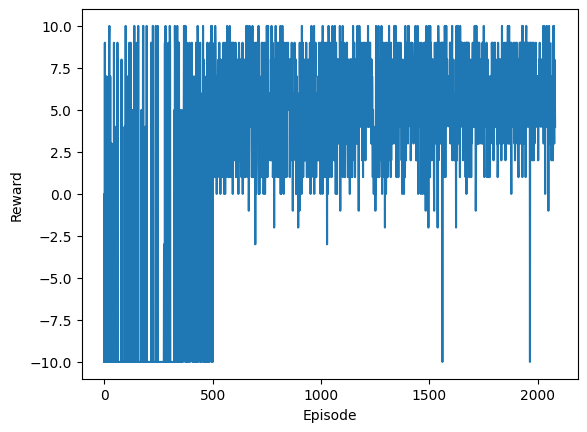

In [7]:
import matplotlib.pyplot as plt

plt.plot(rewards)

plt.xlabel('Episode')  # X-axis label
plt.ylabel('Reward')   # Y-axis label

plt.show()


In [22]:
import time

np.random.seed(int(time.time()))

total_timesteps = int(1e3)
timesteps = 10
termination = False
truncation = False


agent = Agent()
agent.load(name="dqn_test1")

plot_states = []

    
i = np.random.choice(GRID_WORLD.shape[0]) 
j = np.random.choice(GRID_WORLD.shape[1])    

state_id = np.array((1,3))

plot_states.append(state_id)

for timestep in range(20):
    
    if i == timesteps-1:
        truncation = False

    action_idx = agent.sample_action(observation=state_id, epsilon=0)
    transition_tuple = env_step(state_id=state_id, action=actions[action_idx], action_idx=action_idx)
    
    
    state_id = np.array(transition_tuple[3])

    
    plot_states.append(state_id)

            
    if transition_tuple[4] or truncation:
        break
            

/tmp/ipykernel_2499577/15985173.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(T.load(name))


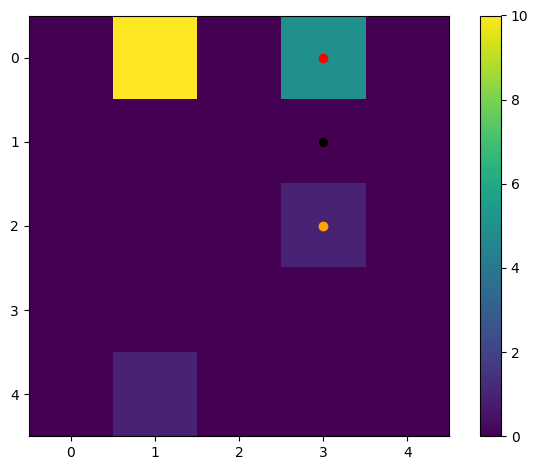

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plot_states = np.array(plot_states)

GRID_WORLD = np.zeros((5,5))
GRID_WORLD[0,1] = 10
GRID_WORLD[0,3] = 5
GRID_WORLD[4,1] = 1
GRID_WORLD[2,3] = 1

# Starting point: Black
# Final point: Orange
# In Between points: Red


im = plt.imshow(GRID_WORLD, cmap='viridis', interpolation='nearest')
plt.colorbar(im)

plt.scatter(x=plot_states[:, 1], y=plot_states[:, 0], color="red")  
plt.scatter(x=plot_states[0, 1], y=plot_states[0, 0], color="black")  
plt.scatter(x=plot_states[-1, 1], y=plot_states[-1, 0], color="orange")  

plt.tight_layout()
plt.show()
